In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Read the book metadata dataset

In [2]:
df = pd.read_parquet('metadata_completed.parquet')
df

,title,creator,birthdate,deathdate,issued,rights,subjects,index,reading ease score,reading ease level,download count
0,The Master Spirit,"Magnay, William, Sir",1855,1917,2022-03-25,Public domain in the USA.,"[London (England), Fiction, Love stories, Adve...",67703,71.3,7th grade,57.0
1,The Family on Wheels,"Oxley, J. Macdonald (James Macdonald)",1855,1907,2017-11-05,Public domain in the USA.,"[Orphans, Juvenile fiction, Siblings, Juvenile...",55891,77.9,7th grade,43.0
2,Three Good Giants\nWhose Ancient Deeds are rec...,"Rabelais, François",1835,1901,2019-04-09,Public domain in the USA.,"[Fantasy fiction, Conduct of life, Juvenile fi...",59235,76.2,7th grade,105.0
3,Drake's Road Book of the Grand Junction Railwa...,"Drake, James, active 1825",<NA>,<NA>,2013-07-31,Public domain in the USA.,[Grand Junction Railway Company (Great Britain...,43367,65.5,8th & 9th grade,127.0
4,Facts and Speculations on the Origin and Histo...,"Chatto, William Andrew",1799,1864,2014-05-04,Public domain in the USA.,"[Playing cards, History, GV]",45584,62.7,8th & 9th grade,158.0
...,...,...,...,...,...,...,...,...,...,...,...
10289,The Social Ladder\nDrawings by Charles Dana Gi...,"Gibson, Charles Dana",1867,1944,2021-04-08,Public domain in the USA.,"[Caricatures and cartoons, United States, Amer...",65026,62.1,8th & 9th grade,73.0
10290,A Walk through Leicester\nbeing a Guide to Str...,"Watts, Susannah",1768,1842,2008-06-24,Public domain in the USA.,"[Leicester (England), Description and travel, DA]",25895,51.2,10th to 12th grade,82.0
10291,The Lone Inn: A Mystery,"Hume, Fergus",1859,1932,2017-08-09,Public domain in the USA.,"[Detective and mystery stories, English fictio...",55310,83.2,6th grade,51.0
10292,Pine to Potomac : $b Life of James G. Blaine: ...,"Cressey, E. K.",<NA>,<NA>,2024-04-07,Public domain in the USA.,"[Politicians, United States, Biography, Blaine...",73345,66.5,8th & 9th grade,86.0


## Chuyển LCC tag có ý nghĩa

In [3]:
# Ý nghĩa của các LCC tag
LCC_dict = {'A': 'General Works',
            'B': 'Philosophy. Psychology. Religion',
            'C': 'Auxiliary Sciences Of History',
            'D': 'World History And History Of Europe, Asia, Africa, Australia, New Zealand, Etc.',
            'E': 'History Of The Americas',
            'F': 'History Of The Americas',
            'G': 'Geography. Anthropology. Recreation',
            'H': 'Social Sciences',
            'J': 'Political Science',
            'K': 'Law',
            'L': 'Education',
            'M': 'Music',
            'N': 'Fine Arts',
            'P': 'Language And Literature',
            'Q': 'Science',
            'R': 'Medicine',
            'S': 'Agriculture',
            'T': 'Technology',
            'U': 'Military Science',
            'V': 'Naval Science',
            'Z': 'Bibliography. Library Science. Information Resources (General)',
            }

def convert(list_subjects: list) -> list:
    for i in range(len(list_subjects)):
        # Nếu thuộc chuẩn LCC thì chuyển về dạng có nghĩa
        if len(list_subjects[i]) <= 3 and list_subjects[i].isupper():
            list_subjects[i] = LCC_dict[list_subjects[i][0:1]]
    return list_subjects

df['subjects'] = df['subjects'].apply(convert)

### Các chủ đề thường xuyên được vào top 10 chủ đề được viết nhiều nhất năm

Trả lời câu hỏi này có thể cho ta biết nhu cầu và mối quan tâm của xã hội, giúp quảng bá các sách có chủ đề này.

In [4]:
from datetime import datetime

# Tìm 10 subjects có nhiều sách nhất của năm year.
def top10subjectsOfYear(year: int):
    # Tìm sách trong năm year.
    books = df[(df['issued'] >= datetime(year, 1, 1)) & (df['issued'] < datetime(year + 1, 1, 1))]
    
    # Lưu tất cả các subject của sách vào subjects.
    subjects = set()
    for subjects_list in books['subjects']:
        subjects.update(subjects_list)
    
    # Đếm số lần xuất hiện của từng subject.
    count_subjects = {key: 0 for key in subjects}
    for subjects_list in books['subjects']:
        for subject in subjects_list:
            count_subjects[subject] += 1
    
    # Sắp xếp giảm dần theo số lần xuất hiện
    sorted_by_value = dict(sorted(count_subjects.items(), key=lambda item: item[1], reverse=True))
    sorted_by_value = list(sorted_by_value.keys())
    
    # Trả về danh sách 10 subjects phổ biến nhất.
    top10 = [sorted_by_value[i] for i in range(0, min(10, len(sorted_by_value)))]
    
    return top10

In [5]:
# Khoảng thời gian
print('start: ', min(df['issued']))
print('end: ', max(df['issued']))

start:  1977-12-01 00:00:00
end:  2024-09-20 00:00:00


In [6]:
year_top10subjects = dict()
for year in range(1977, 2025):
    year_top10subjects[year] = top10subjectsOfYear(year)

Kiểm tra có năm nào không đủ 10 tag không?

In [7]:
print('Less than 10 tags:')
less_10_subjects = dict() 
for year, list_tags in year_top10subjects.items():
    if len(list_tags) < 10:
        print(year, end = ' ')
        less_10_subjects[year] = len(list_tags)

Less than 10 tags:
1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 

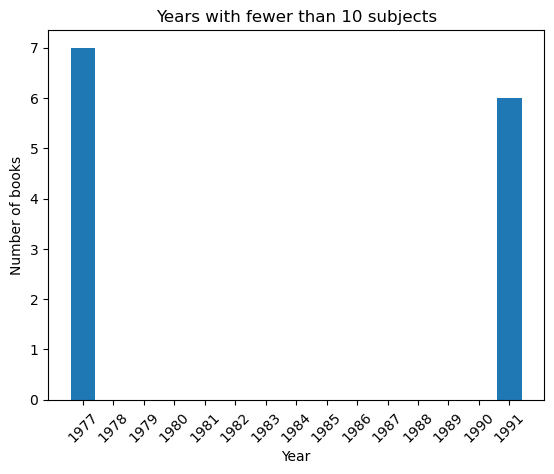

In [8]:
plt.bar(less_10_subjects.keys(), less_10_subjects.values())
plt.xticks(ticks = list(less_10_subjects.keys()), labels = list(less_10_subjects.keys()))
plt.xticks(rotation = 45)
plt.title('Years with fewer than 10 subjects')
plt.xlabel('Year')
plt.ylabel('Number of books');

Một số năm không có đủ 10 subjects phổ biến, nguyên nhân là do thiếu các mẫu của năm đó hoặc năm đó không có sách nào được viết.

In [9]:
# Đếm số lần các tag vào top 10
frequency = dict()
for subjects_list in year_top10subjects.values():
    for subject in subjects_list:
        if subject in frequency.keys():
            frequency[subject] += 1
        else:
            frequency[subject] = 1

In [10]:
# Sắp xếp giảm dần theo số lần vào top 10
sorted_by_value = dict(sorted(frequency.items(), key = lambda item: item[1], reverse = True))

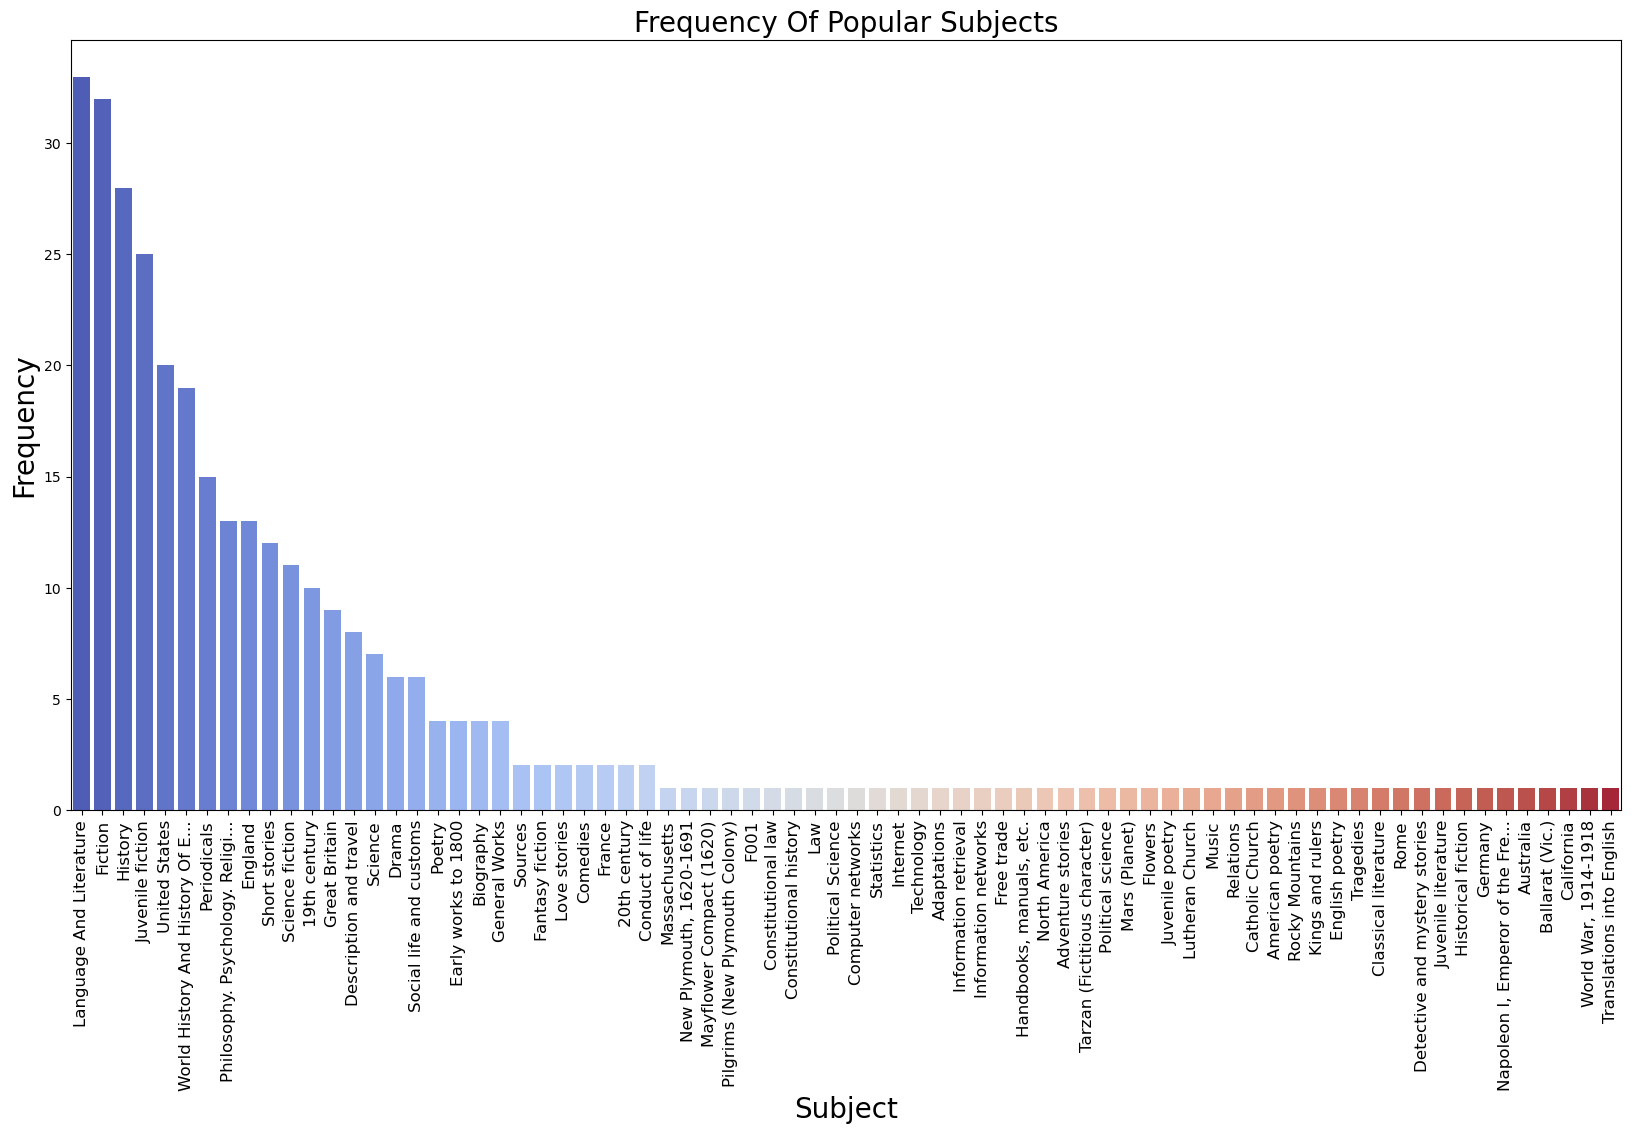

In [11]:
max_length = 30  # Giới hạn độ dài nhãn
labels = list(sorted_by_value.keys())
short_labels = [label[:max_length] + '...' if len(label) > max_length else label for label in labels]

plt.figure(figsize = (20, 10))
sns.barplot(x = short_labels, y = list(sorted_by_value.values()), palette = 'coolwarm')
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel('Subject', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Frequency Of Popular Subjects', fontsize = 20);

Các chủ đề được vào danh sách top 10 chủ đề được viết nhiều nhất năm nhiều lần nhất là: Fiction, Language And Literature, và History.

In [12]:
# Kiểm tra xem 3 chủ đề phổ biến nhất có thịnh hành liên tục cho tới ngày nay không?
lal = [year for year in year_top10subjects.keys() if 'Language And Literature' in year_top10subjects[year]]
fiction = [year for year in year_top10subjects.keys() if 'Fiction' in year_top10subjects[year]]
history = [year for year in year_top10subjects.keys() if 'History' in year_top10subjects[year]]

In [13]:
print(lal)

[1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [14]:
print(fiction)

[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [15]:
print(history)

[1977, 1997, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
